In [11]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
file_id = '11pjeOe6WpR7VQU0rs8stYU0gN6pV7uKy'

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  pro, done = downloader.next_chunk()
  print(pro.progress())
  print(done)
  
downloaded.seek(0)
print('Downloaded file contents are: {}'.format(downloaded.read()))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
import zipfile, os
zip_ref = zipfile.ZipFile('gdrive/My Drive/test.zip', 'r')
zip_ref.extractall('TestData/')
zip_ref.close()

In [0]:
zip_ref2 = zipfile.ZipFile('gdrive/My Drive/train.zip', 'r')
zip_ref2.extractall('TrainData/')
zip_ref2.close()

In [14]:
!pip install livelossplot

In [0]:
import pandas as pd
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np 

In [0]:
SAMPLE_COUNT=85000
TRAINING_RATIO=0.9
IMAGE_SIZE = 96
BATCH_SIZE = 32
MODEL_PLOT_FILE = "model_plot.png"
EPOCHS = 10
VERBOSITY = 1
MODEL_FILE = "gdrive/My Drive/model.h5"
TRAINING_LOGS_FILE = "training_logs.csv"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
TESTING_BATCH_SIZE = 5000
KAGGLE_SUBMISSION_FILE = "gdrive/My Drive/kaggle_submission.csv"

In [0]:
def datasetup(SAMPLE_COUNT, TRAINING_RATIO):    
    training_dir = 'TrainData/'
    data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[1].split('.')[0]) 
    labels = pd.read_csv('gdrive/My Drive/train_labels.csv', encoding='utf8')
    data_frame = data_frame.merge(labels, on = 'id')
    negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
    positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
    data_frame = pd.concat([negatives, positives]).reset_index()
    data_frame = data_frame[['path', 'id', 'label']]
    data_frame['image'] = data_frame['path'].map(imread)
    training_path = '../training'
    validation_path = '../validation'
    for folder in [training_path, validation_path]:
        for subfolder in ['0', '1']:
            path = os.path.join(folder, subfolder)
            os.makedirs(path, exist_ok=True)
    training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])
    data_frame.set_index('id', inplace=True)
    for images_and_path in [(training, training_path), (validation, validation_path)]:
        images = images_and_path[0]
        path = images_and_path[1]
        for image in images['id'].values:
            file_name = image + '.tif'
            label = str(data_frame.loc[image,'label'])
            destination = os.path.join(path, label, file_name)
            if not os.path.exists(destination):
                source = os.path.join('TrainData/', file_name)
                shutil.copyfile(source, destination)
                

    return (training_path, validation_path)

In [9]:
training_path, validation_path=datasetup(SAMPLE_COUNT, TRAINING_RATIO)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
training_data_generator = ImageDataGenerator(rescale=1./255,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            rotation_range=180,
                                            zoom_range=0.4, 
                                            width_shift_range=0.3,
                                            height_shift_range=0.3,
                                            shear_range=0.3,
                                            channel_shift_range=0.3)

In [0]:
def generation(IMAGE_SIZE, BATCH_SIZE, training_data_generator,training_path, validation_path):
    training_generator = training_data_generator.flow_from_directory(training_path,
                                                                    target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                    batch_size=BATCH_SIZE,
                                                                    class_mode='binary')
    validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                                batch_size=BATCH_SIZE,
                                                                                class_mode='binary')
    testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                            target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                            batch_size=BATCH_SIZE,
                                                                            class_mode='binary',
                                                                            shuffle=False)
    return (training_generator, validation_generator, testing_generator)   

In [0]:
training_generator, validation_generator, testing_generator=generation(IMAGE_SIZE, BATCH_SIZE, training_data_generator,training_path, validation_path)

Found 153000 images belonging to 2 classes.
Found 17000 images belonging to 2 classes.
Found 17000 images belonging to 2 classes.


In [0]:
def cancermodel(IMAGE_SIZE, MODEL_PLOT_FILE):     
    #input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    #inputs = Input(input_shape)
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    xception = Xception(include_top=False, input_tensor = input_tensor)(input_tensor)
    nas_net = NASNetMobile(include_top=False, input_tensor = input_tensor)(input_tensor)
    outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(nas_net)])
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(1, activation='sigmoid')(outputs)
    model = Model(input_tensor, outputs)
    model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    model.summary()
    #plot_model(model,
    #        to_file=MODEL_PLOT_FILE,
    #        show_shapes=True,
    #        show_layer_names=True)     
    return model

In [18]:
model=cancermodel(IMAGE_SIZE, MODEL_PLOT_FILE)

Instructions for updating:
Colocations handled automatically by placer.
19996672/19993432 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 3, 3, 2048)   20861480    input_1[0][0]                    
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
_______________________________________________________

In [0]:
def training(EPOCHS, VERBOSITY, MODEL_FILE, TRAINING_LOGS_FILE, training_generator, validation_generator, model):       
    history = model.fit_generator(training_generator,
                                steps_per_epoch=len(training_generator), 
                                validation_data=validation_generator,
                                validation_steps=len(validation_generator),
                                epochs=EPOCHS,
                                verbose=VERBOSITY,
                                callbacks=[PlotLossesKeras(),
                                            ModelCheckpoint(MODEL_FILE,
                                                            monitor='val_acc',
                                                            verbose=VERBOSITY,
                                                            save_best_only=True,
                                                            mode='max'),
                                            CSVLogger(TRAINING_LOGS_FILE,
                                                    append=False,
                                                    separator=';')])
    return history

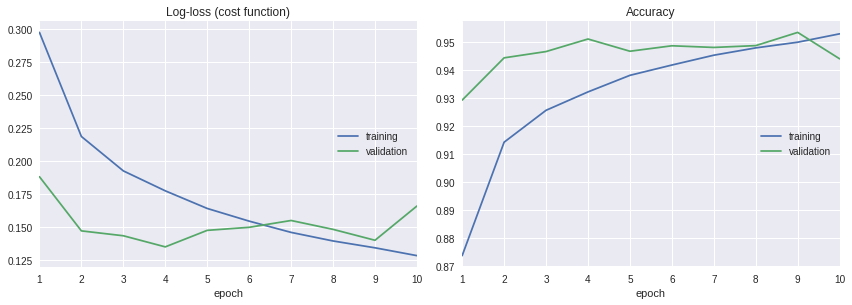

Log-loss (cost function):
training   (min:    0.128, max:    0.297, cur:    0.128)
validation (min:    0.135, max:    0.188, cur:    0.166)

Accuracy:
training   (min:    0.874, max:    0.953, cur:    0.953)
validation (min:    0.929, max:    0.953, cur:    0.944)

Epoch 00010: val_acc did not improve from 0.95329


In [0]:
history=training(EPOCHS, VERBOSITY, MODEL_FILE, TRAINING_LOGS_FILE, training_generator, validation_generator, model)

In [0]:
def kaggletesting(TESTING_BATCH_SIZE, KAGGLE_SUBMISSION_FILE, model):        
    testing_files = glob(os.path.join('TestData/','*.tif'))
    submission = pd.DataFrame()
    for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
        data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[1].split(".")[0])
        data_frame['image'] = data_frame['path'].map(imread)
        images = np.stack(data_frame.image, axis=0)
        predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
        predictions = np.array(predicted_labels)
        predictions_int = np.round(predictions)
        data_frame['label'] = predictions_int
        submission = pd.concat([submission, data_frame[["id", "label"]]])
    submission.to_csv(KAGGLE_SUBMISSION_FILE, index=False, header=True)
    return KAGGLE_SUBMISSION_FILE

In [0]:
KAGGLE_SUBMISSION_FILE=kaggletesting(TESTING_BATCH_SIZE, KAGGLE_SUBMISSION_FILE, model)